# Lab 5 ASTR 400B 


In [23]:
# Import Modules 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import constants as const # import astropy constants
import astropy.units as u
from scipy.optimize import fsolve

# Part A :  Mass to Light Ratios 

Wolf et al. 2010 

$M(<R_{half}) = \frac {4}{G}\sigma^2 R_e$

Where $R_{half}$ = 3D half mass radius 
and $R_e$ is the 2D half mass radius of stars (observed)

Determine which of the following two systems are galaxies:

The system 47 Tuc is observed with:  $\sigma = 17.3$ km/s, $R_e = 0.5$ pc, $L_v \sim 10^5 L_\odot$ 

The system Willman I is observed with: $\sigma = 4.3$ km/s, $R_e = 25$ pc, $L_v = 10^3 L_\odot$

In [24]:
# Gravitational Constant in the desired units
# kpc^3/Gyr^2/Msun
Grav = const.G.to(u.kpc**3/u.Gyr**2/u.Msun)

In [25]:
def WolfMass(sigma, re):
    """ Function that defines the Wolf mass estimator from Wolf+ 2010
    PARAMETERS
    ----------
        sigma: astropy quantity
            1D line of sight velocity dispersion in km/s
        re: astropy quantity
            Effective radius, 2D radius enclosing half the
            stellar mass in kpc
    OUTPUTS
    -------
        mWolf: Returns the dynamical mass within the 
            half light radius in Msun
    """
    
    sigmaKpcGyr = sigma.to(u.kpc/u.Gyr) # velocity dispersion units
    
    mWolf = 4/Grav*sigmaKpcGyr**2*re # Wolf mass estimator
    
    return mWolf

In [26]:
Tuc_47 = WolfMass(17.3*u.km/u.s,0.5e-3*u.kpc)
Lum_tuc = 1e5 * u.Lsun
will_I = WolfMass(4.3*u.km/u.s,25e-3*u.kpc)
Lum_will = 1e3 * u.Lsun

print(f"{Tuc_47:.2e}")
print(f"Mass to light ratio of 47 Tuc: {np.around(Tuc_47/Lum_tuc, 1)}")

print(f"{will_I:.2e}")
print(f"Mass to light ratio of William I: {np.around(will_I/Lum_will,1)}")

1.39e+05 solMass
Mass to light ratio of 47 Tuc: 1.4 solMass / solLum
4.30e+05 solMass
Mass to light ratio of William I: 429.9 solMass / solLum


# Part B :  Stellar to Halo Mass Relation

Following the work of [Moster et al. 2013 (MNRAS, 428, 3121)](https://ui.adsabs.harvard.edu/abs/2013MNRAS.428.3121M/abstract)


`Equation 2:`                  $ \frac{m}{M} = 2N \left [ \left ( \frac{M}{M_1} \right)^{-\beta} + \left (\frac{M}{M_1} \right)^{\gamma} \right]$ 

$m$ = stellar mass, $M$ = halo mass

`Equation 11:`        log $M_1(z) = M_{10} + M_{11} \frac{z}{z+1} $ 

`Equation 12:`        $N(z) = N_{10} + N_{11} \frac{z}{z+1} $

`Equation 13:`         $\beta(z) = \beta_{10} + \beta_{11} \frac{z}{z+1} $

`Equation 14:`         $\gamma(z) = \gamma_{10} + \gamma_{11} \frac{z}{z+1} $

# Q1 

Modify the class below by adding a function called `StellarMass` that uses the `SHMratio` function and returns the stellar mass.

In [27]:
class AbundanceMatching:
    """ Class to define the abundance matching relations from 
    Moster et al. 2013, which relate the stellar mass of a galaxy
    to the expected dark matter halo mass, according to 
    Lambda Cold Dark Matter (LCDM) theory """
    
    
    def __init__(self, mhalo, z):
        """ Initialize the class
        
        PARAMETERS
        ----------
            mhalo: float
                Halo mass in Msun
            z: float
                redshift
        """
        
        #initializing the parameters:
        self.mhalo = mhalo # Halo Mass in Msun
        self.z = z  # Redshift
        
        
    def logM1(self):
        """eq. 11 of Moster 2013
        OUTPUT: 
            M1: float 
                characteristic mass in log(Msun)
        """
        M10      = 11.59
        M11      = 1.195 
        return M10 + M11*(self.z/(1+self.z))  
    
    
    def N(self):
        """eq. 12 of Moster 2013
        OUTPUT: 
            Normalization for eq. 2
        """
        N10      = 0.0351
        N11      = -0.0247
    
        return N10 + N11*(self.z/(1+self.z))
    
    
    def Beta(self):
        """eq. 13 of Moster 2013
        OUTPUT:  power of the low mass slope"""
        beta10      = 1.376
        beta11      = -0.826
    
        return beta10 + beta11*(self.z/(1+self.z))
    
    def Gamma(self):
        """eq. 14 of Moster 2013
        OUTPUT: power of the high mass slope """
        gamma10      = 0.608
        gamma11      = 0.329
    
        return gamma10 + gamma11*(self.z/(1+self.z))
    
    
    def SHMratio(self):
        """ 
        eq. 2 of Moster + 2013
        The ratio of the stellar mass to the halo mass
        
        OUTPUT: 
            SHMratio float
                Stellar mass to halo mass ratio
        """
        M1 = 10**self.logM1() # Converting characteristic mass 
        # to Msun from Log(Msun)
        
        A = (self.mhalo/M1)**(-self.Beta())  # Low mass end
        
        B = (self.mhalo/M1)**(self.Gamma())   # High mass end
        
        Norm = 2*self.N() # Normalization
    
        SHMratio = Norm*(A+B)**(-1)
    
        return SHMratio 
    
 # Q1: add a function to the class that takes the SHM ratio and returns 
# The stellar mass 
    def StellarMass(self):
        """Method to compute the stellar mass
        using eq 2 of Moster+2013 (stellar / halo mass ratio)
        
        Output;
            starMass: float, stellar mass in Msun"""
        
        starMass = self.mhalo*self.SHMratio()

        return starMass




# Part C : Plot the Moster Relation

Reproduce the below figure from Moster + 2013 
Plot this for z=0, 0.5, 1, 2

![mos](./MosterFig.png)

In [28]:
mh = np.logspace(10,15,1000) # Logarithmically spaced array

In [29]:
# Define Instances of the Class for each redshift
MosterZ0 = AbundanceMatching(mh,0) # z = 0
MosterZ0_5 = AbundanceMatching(mh,0.5) # z = 0.5
MosterZ1 = AbundanceMatching(mh,1) # z = 1
MosterZ2 = AbundanceMatching(mh,2) # z = 2


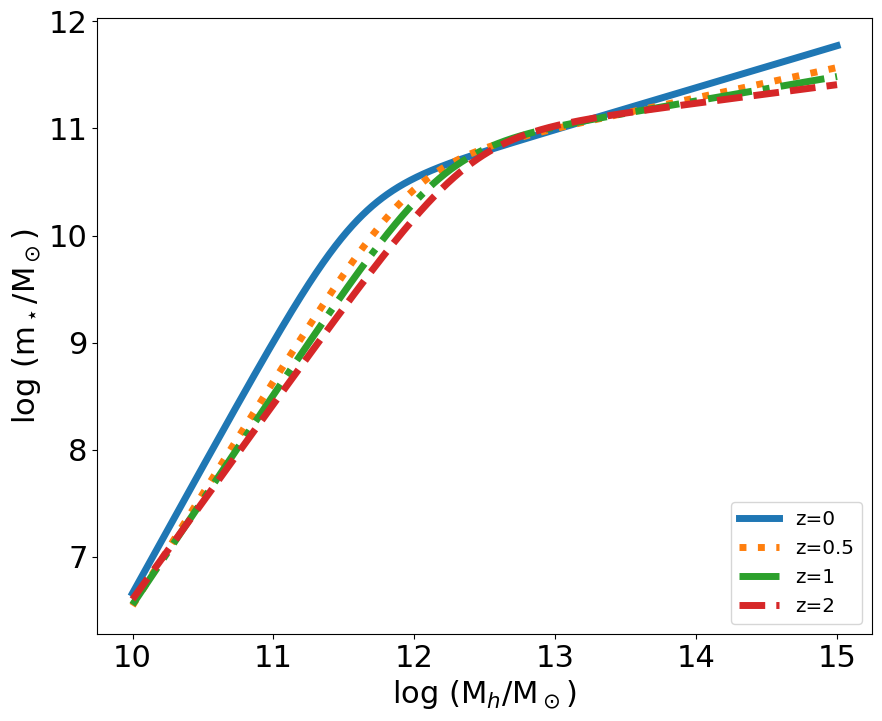

In [30]:

fig,ax = plt.subplots(figsize=(10,8))


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot z = 0
plt.plot(np.log10(mh), np.log10(MosterZ0.StellarMass()),
         linewidth = 5, label='z=0')

# Continue plotting for the other redshifts here

# Plot z = 0.5
plt.plot(np.log10(mh), np.log10(MosterZ0_5.StellarMass()),
         linewidth = 5, linestyle = 'dotted', label='z=0.5')

# Plot z = 1
plt.plot(np.log10(mh), np.log10(MosterZ1.StellarMass()),
         linewidth = 5, linestyle = 'dashdot', label='z=1')

# Plot z = 2
plt.plot(np.log10(mh), np.log10(MosterZ2.StellarMass()),
         linewidth = 5, linestyle = 'dashed', label='z=2')


# Axes labels 
plt.xlabel('log (M$_h$/M$_\odot$)',fontsize=22) 
plt.ylabel('log (m$_\star$/M$_\odot$)', fontsize=22)

# Legend
plt.legend(loc='lower right',fontsize='x-large')

# save the file 
plt.savefig("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/ASTR400B/Labs/Lab5/AbundanceMatching_Lab5.png"      )



# Part D

# Q1

In studies that have modeled the Magellanic Clouds prior to 2010, the LMC is traditioanlly modeled with a halo (dark matter) mass of order $3 \times 10^{10}$M$_\odot$.  

## A) 
According to $\Lambda$CDM theory, what should be the stellar mass of the LMC halo be at z=0?  

## B) 
How does this stellar mass compare to the actual observed stellar mass of the LMC at the present day of ~$3 \times 10^9$ M$_\odot$ ? 

## C) 
What is the $\Lambda$CDM expected halo mass for the LMC (using Abundance Matching)? 

In [31]:
# LMC halo mass
haloLMC1 = 3e10 # traditional models

# Abundance matching object
LMC1 = AbundanceMatching(haloLMC1, 0)


In [32]:
# Find the stellar mass
LMC1star = LMC1.StellarMass()

print(LMC1star/1e9, 3)
print(LMC1star/3e9 * 100)

0.061582173613615045 3
2.0527391204538348


In [33]:
# say we know that LMC stellar mass = 3e9 Msun
#  what is the halo mass?

haloLMC2 = 17e10

LMC2 = AbundanceMatching(haloLMC2, 0)

In [34]:

LMC2star = LMC2.StellarMass()

print(np.round(LMC2star/1e9, 3))

3.201


# Q2

## A) 
What is the expected stellar mass of an L* galaxy at z=0? 

## B)
What is the expected stellar mass of an L* galaxy at z = 2? 

In [35]:
# Find the characteristic Halo mass at z = 0

M1halo_z0 = MosterZ0.logM1()
print(f'Log M1, z = 0: {M1halo_z0}')

Log M1, z = 0: 11.59


In [36]:
# Create a new instance of the class, with halo mass = log M1 at z = 0

M1z0 = AbundanceMatching(10 ** M1halo_z0, 0)

In [37]:
# Determine the stellar mass of that halo
M1star_z0 = M1z0.StellarMass()
print(f'Stellar mass of L * gal at z = 0: {M1star_z0/1e10} (1e10 M sun)')

Stellar mass of L * gal at z = 0: 1.3655484589299245 (1e10 M sun)


In [38]:
# Repeating at z = 2

M1halo_z2 = MosterZ2.logM1()
print(f'Log M1, z = 2: {M1halo_z2}')

Log M1, z = 2: 12.386666666666667


In [39]:
# Create a new instance of the class, with halo mass = log M1 at z = 2

M1z2 = AbundanceMatching(10 ** M1halo_z2, 2)

In [40]:
# Determine the stellar mass of that halo
M1star_z2 = M1z2.StellarMass()
print(f'Stellar mass of L * gal at z = 2: {M1star_z2/1e10} (1e10 M sun)')

Stellar mass of L * gal at z = 2: 4.538969033454143 (1e10 M sun)
